# Methodology

In [1]:
import numpy as np
import sys
sys.path.append('../')

from src.d02_intermediate.classifier_data_api import ClassifierDataApi
from src.d04_modeling.propositional_classifier import PropositionalClassifier, andClassifier, orClassifier

data = ClassifierDataApi()

We propose that the tiebreaker is a classifier on the set of geopgraphic blocks. Each block is identified by its geoid. The general architecture of the tiebreaker is shown in the following diagram:

![General Tiebreaker](images/methodology-general_tiebreaker.png)

The classification is divided in two steps, eligibility and classification. Each of them has a different rationale and function:

1. The eligibility step selects blocks which should be considered for the tiebreaker. This is a qualitative step, that functions to consider non-demographic block features and align the tiebreaker with greater policy goals. These criteria may not depend on the definition of focal students, so that they would not be satisfied by an "optimal" tiebreaker necessairily. For example, in this step we can consider criteria such as:
    
    a. Is the block in a neighborhood with low access to resources?
    
    b. Is the block in a previously red-lined zone?
    
    c. Is the block in a neighborhood with high percentage of focal students?
    
    d. Does the block contains a federal public housing project?
    

2. The qualification step optimizes the block selection by maximizing the number of focal students receiving a tiebreaker while minimizing the number of non-focal students receiving a tiebreaker. This is a mathematical step, and it crucially depends on the definition of focal students. Only eligible blocks are considered.

### Q: Why do we need both of these criteria?

Both of these steps are, in our view, necessary.

The eligibility step ensures that focal students with greater access to resources do not receive the same type of priority as others and allows for the incorporation of different criteria (such as public housing) that are in the policy text but are not in the definition of focal students directly.

The qualification criteria provides some mathematical optimality guarantee. Besides, it reduces the gameability of the system: the eligibility step is deterministic, and often based on criteria that do not depend on demographic changes. A non-focal family who wants to take advantage of the tiebreaker, aware of the eligibility criteria, could move to a block that satisfies those criteria; if there was no qualification step then they would certainly receive the tiebreaker. However with the qualification step the percentage of focal students in a block is recomputed (hopefully annually or biannually), so that displacement could cause a block to lose its tiebreaker.

### Q: Where can I see more of your thought process/explanation of the tiebreaker?

Our development of the tiebreaker is reflected on notebooks

1. and-or-classifier (this notebooke is very helpful to understand tiebreaker initialization)
2. evaluate-models
3. neighborhood-proxy
4. eligibility

## Data

We propose that the tiebreaker uses the intersection students (both AALPI and FRL) as the focal group.

In [2]:
#'Focal' ---> students that are either FRL or  AALPI      (~64%)

#'AALPI' ---> students that are        AALPI              (~36%)
#'FRL'   ---> students that are        FRL                (~52%)
#'AA'    ---> students that are        African-American   (~6%)

#'Both'  ---> students that are both   FRL and AALPI      (~24%)
#'AAFRL' ---> students that are both   FRL and AA         (~4%)

proposed_focal_group = 'Both'  

#RMK: We strongly encourage you to try out a narrower definition of focal group. AAFRL for example.

We use grades TK-5 data:

In [3]:
#'tk5'   --->  data for TK-5  students
#'tk12'  --->  data for TK-12 students

proposed_grades_range = 'tk5'

## Proposed Equity Tiebreaker

Our equity tiebreaker has two eligibility criteria. A block satisfying EITHER of those is eligible:

1. The block contains a federal (non-senior) public housing project
2. The block is in a previously red-lined zone

![Proposed Tiebreaker](images/methodology-proposed_tiebreaker.png)

We chose those criteria to be coherent with the policy text:

“The equity tiebreaker will be applied to applicants who either reside in Federal public housing or in historically underserved areas of San Francisco.”


In [4]:
proposed_eligibility_classifier = orClassifier(["Housing", "Redline"], binary_var=[0,1])
proposed_equity_tiebreaker = andClassifier(["pct"+proposed_focal_group], positive_group= "n"+proposed_focal_group,
                                           frl_key=proposed_grades_range,
                                           eligibility_classifier=proposed_eligibility_classifier)

Loading Block FRL data...Adding African-American counts to FRL data...
1.1675
Loading Block Demographic data...0.2313
Loading Student Demographic data...2.5756


All points in the following curve (knows as the ROC curve) are optimal:

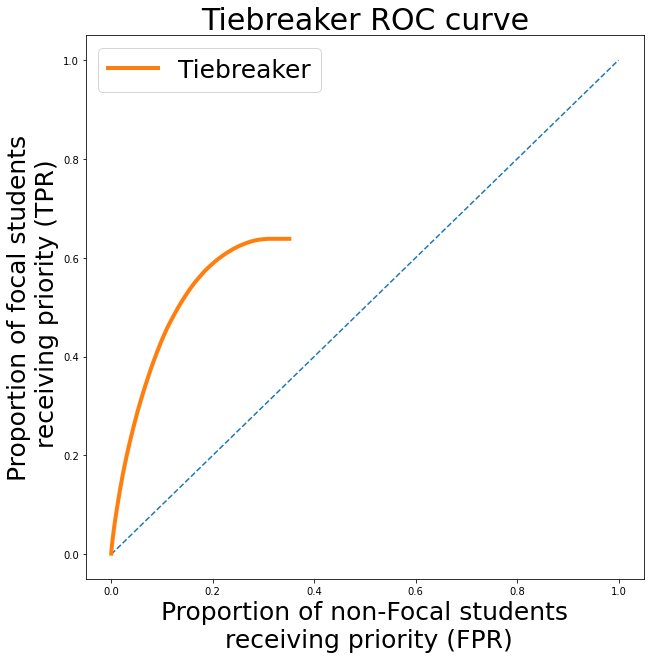

<AxesSubplot:title={'center':'Tiebreaker ROC curve'}, xlabel='Proportion of non-Focal students\n receiving priority (FPR)', ylabel='Proportion of focal students\n receiving priority (TPR)'>

In [5]:
proposed_equity_tiebreaker.plot_roc(np.linspace(0.,1., 100))

This curve illustrates the trade-off between false positives (non-focal students receiving the tiebreaker) and true positives (focal students receiving the tiebreaker). Note that we can achieve a true positive rate of around 63% at most. That is, only 63% of the focal students live in a previously red-lined zone or in a block with public housing. This illustrates how the eligibility criteria serves to bring the focal student definition back to the more strict criteria delimited in the policy text, as we are not targeting focal students outside of the eligible areas.

The equity tiebreaker requires then a threshold. This threshold is the percentage of focal students necessary to qualify a block.

In [6]:
#Test several values. Our recomendations depend on the focal group. Some examples:

#'Focal' ---> ~70% (0.70)
#'Both'  ---> ~35% (0.35)
#'AAFRL' ---> ~5%  (0.05)

proposed_threshold = 0.35

We can view the result on the map (yellow blocks receive the tiebreaker):

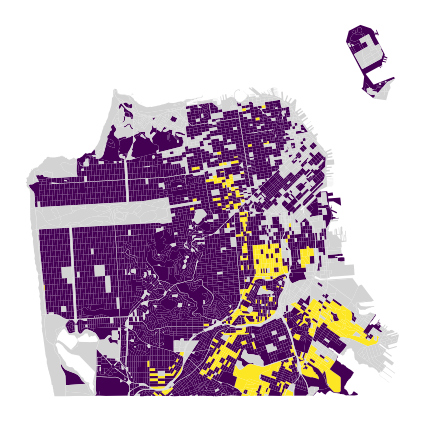

In [7]:
ax = proposed_equity_tiebreaker.plot_map(proposed_threshold)

## Benchmark Tiebreaker

To make sure the eligibility criteria are not too restrictive, we would like to compare the performance of our proposed tiebreaker against a benchmark tiebreaker. In the benchmark tiebreaker all blocks are eligible. Then the tiebreaker will simply optimize block classification based on the percentage of focal students.

In [8]:
proposed_benchmark_tiebreaker = andClassifier(["pct"+proposed_focal_group], positive_group="n"+proposed_focal_group)

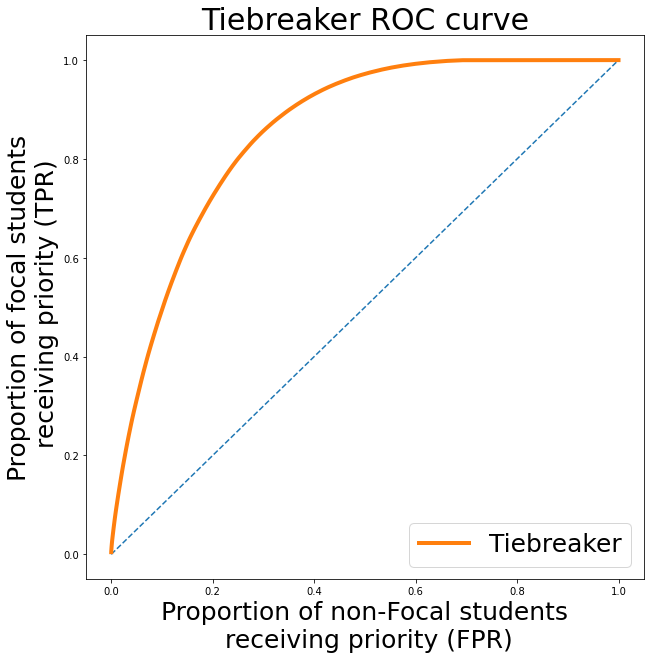

In [9]:
ax = proposed_benchmark_tiebreaker.plot_roc(np.linspace(0.,1., 100))

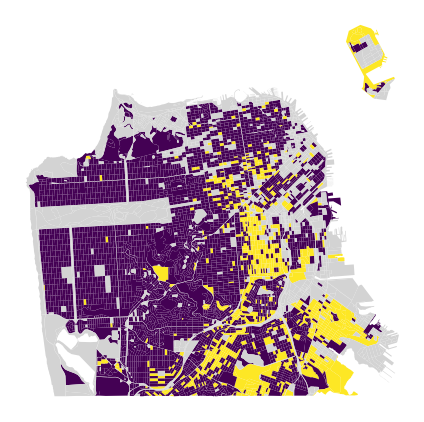

In [10]:
ax = proposed_benchmark_tiebreaker.plot_map(proposed_threshold)

In [11]:
proposed_benchmark_tiebreaker.fpr(proposed_threshold)

0.20262375649003211

## Redlining

We also want to be sure to target historically redlined areas of SFUSD, as those are the ones that have been underserved and oppressed by residential and educational systems. Thus, we will load, process, and clean the ```redlining_data``` set, which comes from [Mapping Inequality](https://dsl.richmond.edu/panorama/redlining/#loc=12/37.83/-122.464&city=san-francisco-ca&area=null&text=downloads). Mapping Inequality is a broad academic initiative working to create maps that illustrate the history of redlining and racial inequality in the United States. 

The ```holc_grade``` corresponds to a grade A-D assigned by the HOLC for the perceived credit-worthiness of each area, and according to mortgage security risk. Grade A is deemed as the highest grade, while grade D were the areas that the HOLC sought to redline -- as illustrated by the red color. HOLC marked **disproportionately African American and minority areas** as grade D to indicate that they were "hazardous." As a result, such policies worked to segregate racial areas and systematically prevented underserved groups from receiving loans through a process today known as **redlining**. 

Loading Block FRL data...0.1935
Loading Block Demographic data...0.1902
Loading Student Demographic data...1.0711


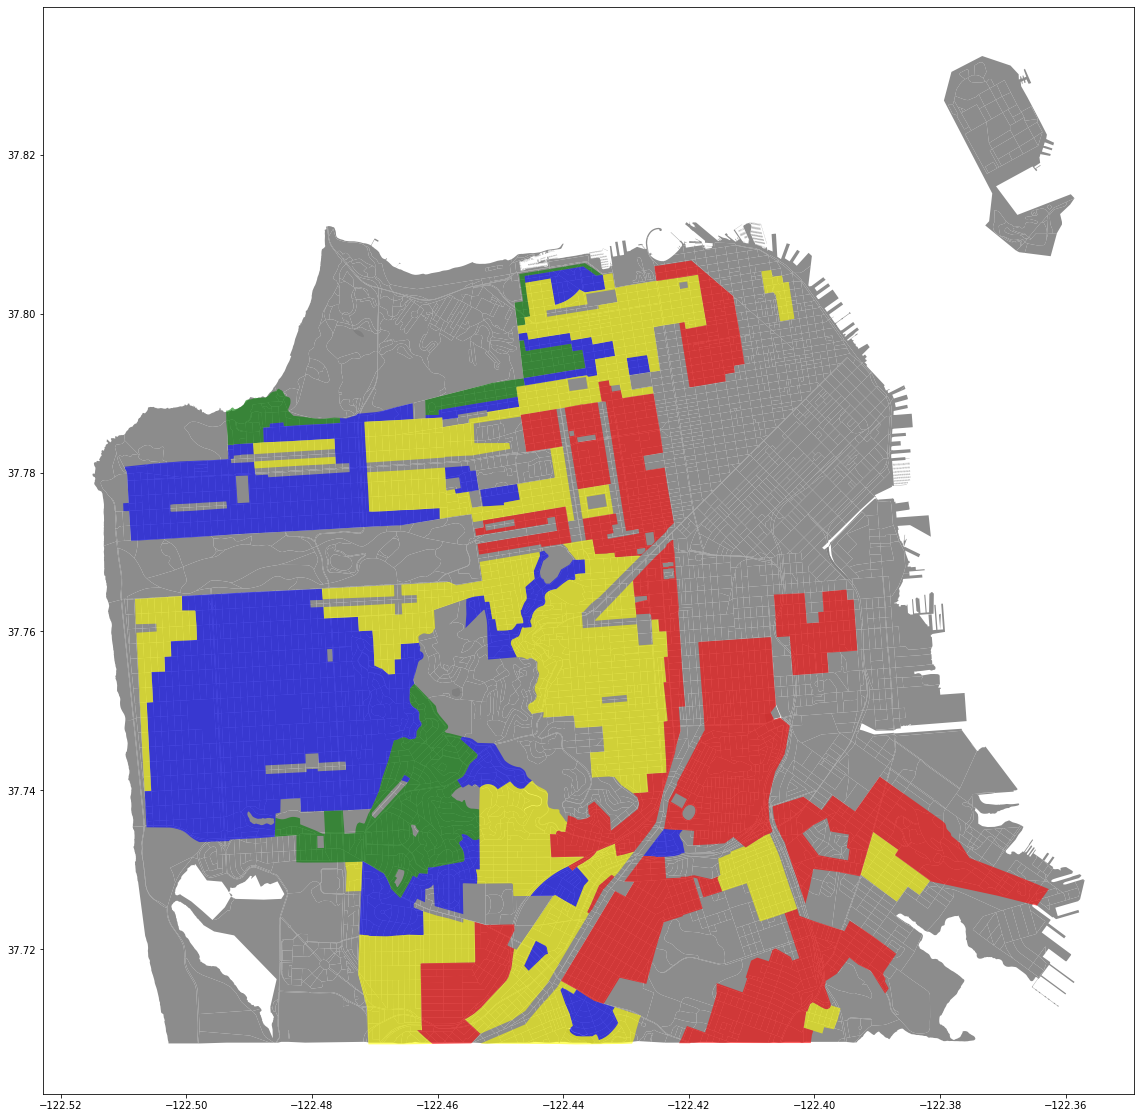

In [12]:
ax = data.plot_redline_data()

The dataset also includes some area descriptions, which can express the racist connotations of the redlining practice:

In [13]:
redline_data = data.get_redline_map_data()
print("grade A example:", redline_data.loc[redline_data['holc_grade'] == 'A']['area_description_data'][0])
print("\n")
print("grade D example:", redline_data.loc[redline_data['holc_grade'] == 'D'].reset_index()['area_description_data'][0])

grade A example: {'1': 'This area consists of 35 irregularly-shaped blocks, the greater portion of which is known as Sea Cliff, located at the westerly end of the area. The narrow strip from 27th Avenue east to 16th Avenue is an older district, but it is highly regarded as a residential area even though some of the residences range up to 30 years in age. In Sea Cliff proper the oldest structure is approximately 18 years old, the bulk of the houses having been built ten years ago. Sea Cliff is highly restricted to single-family residences, both by ordinance and deed. The other section is zoned by ordinance only, and a few four-family flats and one or two apartments were built in this district before the zoning ordinance came into effect. This does not have a detrimental influence, however. The appraised values of the residences in Sea Cliff range from $9500 to $50,000, and in the area lying to the east, range from $5,000 to $25,000. The area is inhabited largely by professional and busi